# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [214]:
# откройте данные: ваш код здесь
import numpy as np
import pandas as pd

data = pd.read_csv('data/spam_or_not_spam.csv')
data

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [215]:
# рассчитайте частоты для классов : ваш код здесь
data['label'].value_counts(normalize=True)

label
0    0.833333
1    0.166667
Name: proportion, dtype: float64

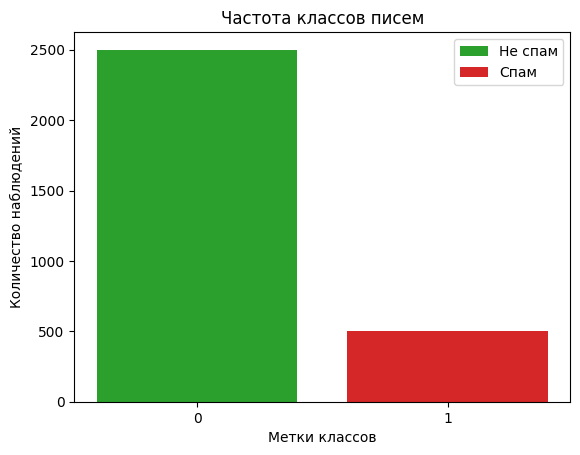

In [216]:
# визуализируйте результат: ваш код здесь
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(data['label'].value_counts().index.astype('str'), 
        data['label'].value_counts().values,
        label=['Не спам', 'Спам'],
        color=['tab:green', 'tab:red'])
ax.set_xlabel('Метки классов')
ax.set_ylabel('Количество наблюдений')
ax.set_title('Частота классов писем')
ax.legend()
plt.show()

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [217]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [218]:
#ваш код здесь
# Заменяем пустые строки
data.loc[data['email']=='', 'email'] = np.nan
# Заменяем строки из пробельных символов (заполняем пропуски в маске на False, т.к. иначе будет выдавать ошибку при её применении)
data.loc[data['email'].str.isspace().fillna(False), 'email'] = np.nan
# Удаляем пропуски
data = data.dropna()

C:\Users\Blooodniy\AppData\Local\Temp\ipykernel_7912\1560551692.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[data['email'].str.isspace().fillna(False), 'email'] = np.nan


Переводим данные в векторный вид:

In [219]:
data.shape

(2997, 2)

In [220]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [221]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [222]:
#ваш код здесь
# X у нас уже определён, как X
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [223]:
#ваш код здесь
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [224]:
#ваш код здесь
print(round(y_test.mean(), 3))

0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [225]:
#ваш код здесь
# Т.к. сказано, что "ComplementNB — улучшенная версия MultinomialNB, стабильно показывает более высокое качество в задачах классификации текстов":
from sklearn.naive_bayes import ComplementNB

cnb_clf = ComplementNB(alpha=0.01)
cnb_clf.fit(X_train, y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [226]:
#ваш код здесь
from sklearn.metrics import classification_report

y_pred = cnb_clf.predict(X_test)
print('Значения метрик на тестовом наборе:\n')
print(classification_report(y_test, y_pred, digits=3))

Значения метрик на тестовом наборе:

              precision    recall  f1-score   support

           0      0.986     1.000     0.993       626
           1      1.000     0.927     0.962       124

    accuracy                          0.988       750
   macro avg      0.993     0.964     0.978       750
weighted avg      0.988     0.988     0.988       750



Нарисуйте ROC-кривую:

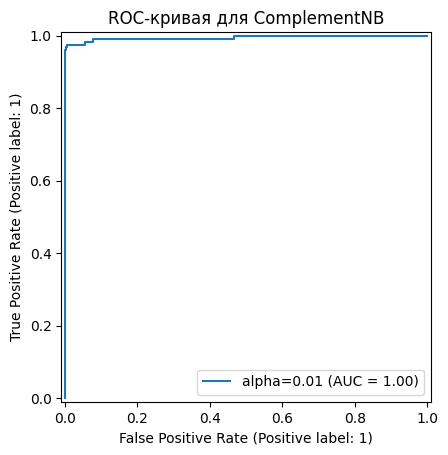

In [227]:
#ваш код здесь
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(cnb_clf, X_test, y_test, name=f'alpha={0.01}')
plt.title('ROC-кривая для ComplementNB')
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [228]:
#ваш код здесь
from sklearn.model_selection import GridSearchCV
# Задаём сетку параметров
grid = {'alpha': np.linspace(0.001, 10, 50)}
# Проводим подбор гиперпараметров на 5 фолдах
gscv = GridSearchCV(ComplementNB(),
                    param_grid=grid,
                    cv=5,
                    n_jobs=-1)
gscv.fit(X_train, y_train)
y_pred_gscv = gscv.predict(X_test)
print(f'Лучшее значение параметра alpha = {gscv.best_params_["alpha"]:.3f}, Лучшее значение accuracy = {gscv.best_score_:.3f}')
print('\nЗначения метрик на тестовом наборе:\n')
print(classification_report(y_test, y_pred_gscv, digits=3))

Лучшее значение параметра alpha = 0.409, Лучшее значение accuracy = 0.992

Значения метрик на тестовом наборе:

              precision    recall  f1-score   support

           0      0.995     0.998     0.997       626
           1      0.992     0.976     0.984       124

    accuracy                          0.995       750
   macro avg      0.994     0.987     0.990       750
weighted avg      0.995     0.995     0.995       750



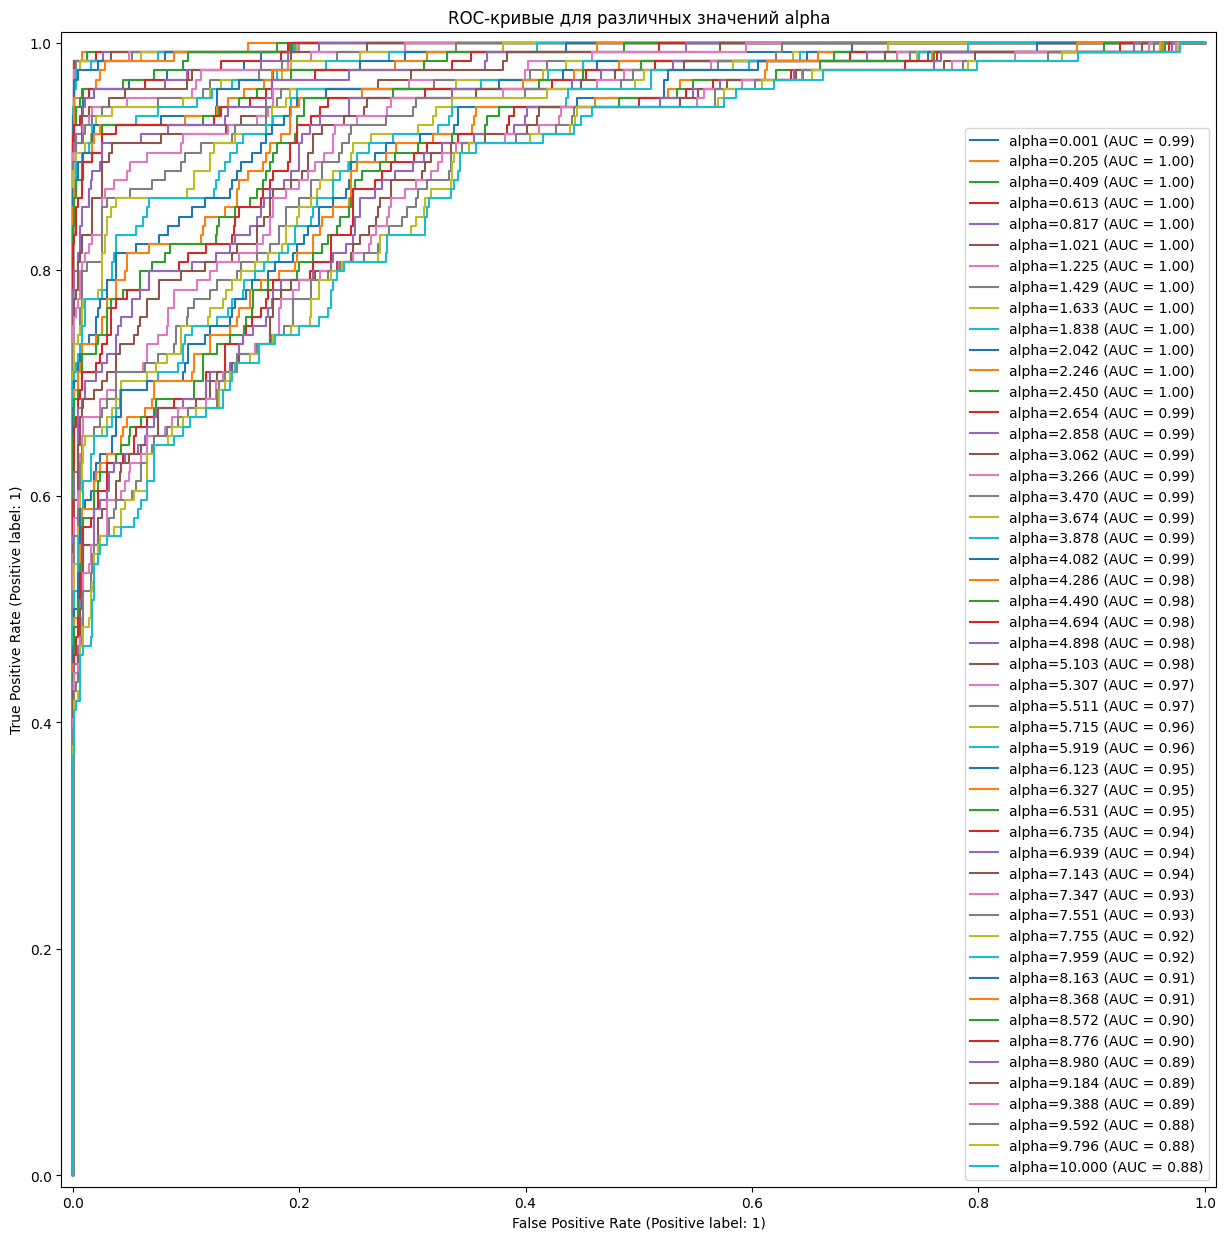

In [229]:
plt.figure(figsize=(15, 15))
for alpha in np.linspace(0.001, 10, 50):
    # Создаём и обучаем модель с заданным параметром
    model = ComplementNB(alpha=alpha)
    model.fit(X_train, y_train)
    # ROC-кривая для конкретного значения параметра
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=plt.gca(), name=f'alpha={alpha:.3f}')
plt.title('ROC-кривые для различных значений alpha')
plt.show()

Вывод: Можно заметить, что качество классификации существенно меняется, в зависимости от значения параметра $\alpha$. Тем не менее значение площади под кривой остаётся близким к 1 в довольно широком диапазоне значений параметра.